In [1]:
# 구글 드라이브 MOUNT
from google.colab import drive
drive.mount('/content/drive')

# github와 연동하고 싶은 폴더로 이동
%cd /content/drive/MyDrive/study_DL/Study_DL


Mounted at /content/drive
/content/drive/MyDrive/study_DL/Study_DL


참고 사이트: https://junstar92.tistory.com/113

# 매우 간단한 오토인코더 만들기

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

In [3]:
#인코딩 될 표현(representation)의 크기
encoding_dim = 32

# 입력플레이스홀더
input_img = Input(shape = (784, ))

# 인코딩 층
encoded = Dense(encoding_dim, activation = 'relu')(input_img)

# 디코딩 층
decoded = Dense(784, activation = 'sigmoid')(encoded)


In [4]:
# 입력을 입력의 재구성으로 매핑할 모델
autoencoder = Model(input_img, decoded)

In [5]:
# 분리된 인코더 모델
encoder = Model(input_img, encoded)

In [6]:
# 분리된 디코더 모델

## 인코딩된 입력을 위한 플레이스홀더
encoded_input = Input(shape = (encoding_dim,))

## 오토인코더 모델의 마지막 레이어 층 얻기
decoder_layer = autoencoder.layers[-1]

## 디코더 모델 생성
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [7]:
# 모델 컴파일

autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [8]:
# mnist 숫자를 활용해 오토인코더 적용하기
from keras.datasets import mnist
import numpy as np

## 레이블은 버렷
(x_train, _), (x_test, _) = mnist.load_data()


11490434/11490434 [==============================] - 2s 0us/step


In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
# 0~1사이로 정규화 
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

# 28*28(784) 이미지를 784의 벡터로 변형
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [11]:
# 오토인코더 학습
autoencoder.fit(x_train, x_train,
                epochs = 50,
                batch_size = 256,
                shuffle = True,
                validation_data = (x_test, x_test))

Epoch 1/50
235/235 [==============================] - 6s 6ms/step - loss: 0.2777 - val_loss: 0.1901
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1696 - val_loss: 0.1521
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1432 - val_loss: 0.1325
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1273 - val_loss: 0.1201
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1172 - val_loss: 0.1121
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1106 - val_loss: 0.1065
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1057 - val_loss: 0.1024
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1019 - val_loss: 0.0992
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0992 - val_loss: 0.0968
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0973 - val_loss: 0.0952

In [12]:
# 정상적으로 인코더와 디코더를 분리했는지 확인하기 위해 확인해보기
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# 검증 데이터
valid_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


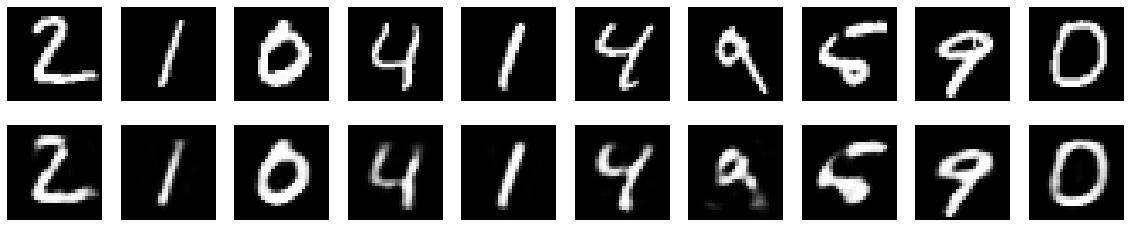

In [13]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize = (20, 4))

for i in range(1, 11):
  ax = plt.subplot(2, 10, i)

  # 원본 데이터
  plt.imshow(x_test[i].reshape((28, 28)), cmap = 'gray')
  plt.axis('off')

  # 오토인코더로 재구성된 데이터
  ax = plt.subplot(2, 10, i + 10)
  plt.imshow(decoded_imgs[i].reshape((28,28)), cmap = 'gray')
  plt.axis('off')
plt.show()


In [14]:
encoded_imgs.mean()

8.612942

위와 같은 처리는 출력이 hidden layer의 유닛크기(32)에만 영향을 받았고, 이런 상황에서는 PCA와 비슷하게 학습함.
조금 더 효율적인 압축을 위해서 sparsity(희소성)을 추가해주는 방법이 있음. 

# sparsity를 추가한 오토인코더 생성
- keras의 regularizers 모듈 인자를 적용하여 학습이 가능함

In [15]:
from keras import regularizers

In [16]:
encoding_dim = 32

input_img = Input(shape = (784,))
encoded = Dense(encoding_dim, activation = 'relu',
                kernel_regularizer = regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation = 'sigmoid')(encoded)

In [17]:
autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

encoded_input = Input(shape = (encoding_dim,))
decoded_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoded_layer(encoded_input))

In [18]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs = 100,
                batch_size = 256,
                validation_data = (x_test, x_test))

Epoch 1/100
235/235 [==============================] - 2s 5ms/step - loss: 0.3300 - val_loss: 0.2405
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2219 - val_loss: 0.2048
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1967 - val_loss: 0.1865
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1814 - val_loss: 0.1736
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1698 - val_loss: 0.1630
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1603 - val_loss: 0.1544
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1524 - val_loss: 0.1472
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1462 - val_loss: 0.1418
Epoch 9/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1415 - val_loss: 0.1377
Epoch 10/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1379 - val_l

In [19]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


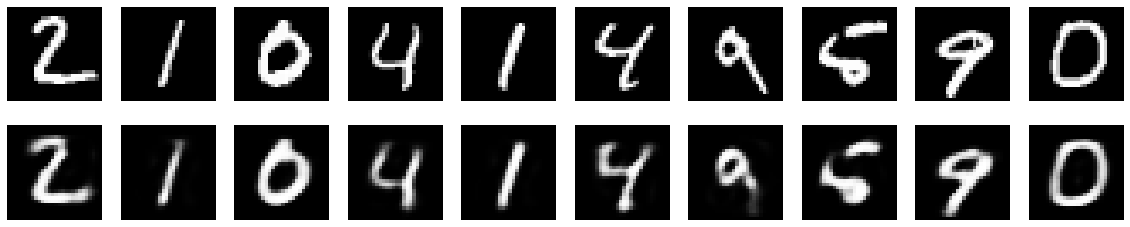

In [20]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize = (20, 4))

for i in range(1, 11):
  ax = plt.subplot(2, 10, i)

  # 원본 데이터
  plt.imshow(x_test[i].reshape((28, 28)), cmap = 'gray')
  plt.axis('off')

  # 오토인코더로 재구성된 데이터
  ax = plt.subplot(2, 10, i + 10)
  plt.imshow(decoded_imgs[i].reshape((28,28)), cmap = 'gray')
  plt.axis('off')
plt.show()

In [21]:
encoded_imgs.mean()

1.3026955

- 그닥 큰 차이가 없음
- 대신 인코딩된 데이터의 sparsity가 다름
  - 기존에는 8.62였는데 이 모델은 1.30이 나옴

# 좀 더 Deep한  오토인코더 생성

In [22]:
encoding_dim = 32

input_img = Input(shape = (784,))

encoded = Dense(128, activation = 'relu')(input_img)
encoded = Dense(64, activation = 'relu')(encoded)
encoded = Dense(encoding_dim, activation = 'relu')(encoded)

decoded = Dense(64, activation = 'relu')(encoded)
decoded = Dense(128, activation = 'relu')(decoded)
decoded = Dense(784, activation = 'sigmoid')(decoded)


In [23]:
autoencoder = Model(input_img, decoded)

In [25]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape = (encoding_dim, ))
decoded_layer = autoencoder.layers[4](encoded_input)
decoded_layer = autoencoder.layers[5](decoded_layer)
decoded_layer = autoencoder.layers[6](decoded_layer)
decoder = Model(encoded_input, decoded_layer)

In [27]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(x_train, x_train, 
                epochs = 100,
                batch_size = 256,
                validation_data = (x_test, x_test))

Epoch 1/100
235/235 [==============================] - 4s 6ms/step - loss: 0.2576 - val_loss: 0.1744
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1564 - val_loss: 0.1415
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1355 - val_loss: 0.1284
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1264 - val_loss: 0.1216
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1203 - val_loss: 0.1165
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1153 - val_loss: 0.1114
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1113 - val_loss: 0.1086
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1088 - val_loss: 0.1065
Epoch 9/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1066 - val_loss: 0.1042
Epoch 10/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1047 - val_lo

In [28]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 1ms/step


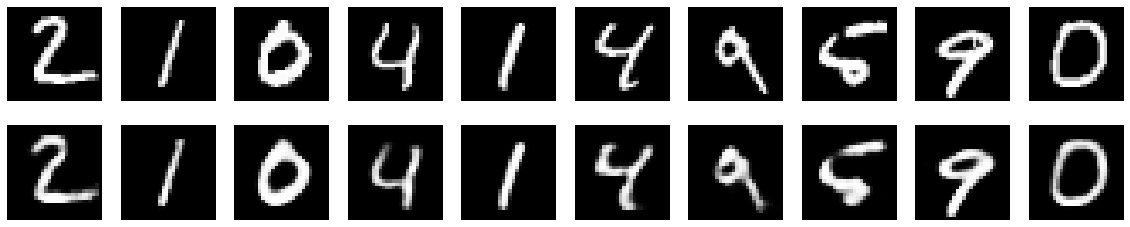

In [29]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize = (20, 4))

for i in range(1, 11):
  ax = plt.subplot(2, 10, i)

  # 원본 데이터
  plt.imshow(x_test[i].reshape((28, 28)), cmap = 'gray')
  plt.axis('off')

  # 오토인코더로 재구성된 데이터
  ax = plt.subplot(2, 10, i + 10)
  plt.imshow(decoded_imgs[i].reshape((28,28)), cmap = 'gray')
  plt.axis('off')
plt.show()

In [30]:
encoded_imgs.mean()

8.123236

- 좀더 깊은 층을 쌓으니까 loss가 줄어들고 그림도 어느정도 잘 나온거 같음

# Convnet 오토인코더 생성
- 이미지 데이터를 input으로 넣으니까 합성곱 연산으로 층을 쌓아 보겠음
- 당연히 성능이 좋을 것으로 예상~
- 인코더는 conv2d, maxpooling2d, 디코더는 conv2d, upsampling2d로 구성

In [31]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [32]:
# 이미지 input에 맞게 reshape
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [33]:
from keras.layers import *

In [80]:
# input 
input_img = Input(shape = (28, 28, 1))

# encoding
x = Conv2D(16, 3, activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D(2, padding = 'same')(x)
x = Conv2D(8, 3, activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(2, padding = 'same')(x)
x = Conv2D(8, 3, activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D(2, padding = 'same')(x)

# decoding
x = Conv2D(8, 3, activation = 'relu', padding = 'same')(encoded)
x = UpSampling2D(2)(x)
x = Conv2D(8, 3, activation = 'relu', padding = 'same')(x)
x = UpSampling2D(2)(x)
x = Conv2D(16, 3, activation = 'relu')(x)
x = UpSampling2D(2)(x)
decoded = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(x)

In [81]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy')


In [82]:
autoencoder.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 7, 7, 8)           584

In [84]:
encoder = Model(input_img, encoded)

decoder_input = Input(shape = (4, 4, 8))
decoder_layer = autoencoder.layers[7](decoder_input)
for i in range(8, len(autoencoder.layers)):
  decoder_layer = autoencoder.layers[i](decoder_layer)

decoder = Model(decoder_input, decoder_layer)

In [64]:
autoencoder.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 7, 7, 8)           584

In [65]:
from tensorflow.keras.callbacks import TensorBoard

In [85]:
autoencoder.fit(x_train, x_train,
                batch_size = 256,
                epochs = 100,
                validation_data = (x_test, x_test),
                callbacks = [TensorBoard(log_dir = '/tmp/autoencoder')])


Epoch 1/100
235/235 [==============================] - 5s 9ms/step - loss: 0.3077 - val_loss: 0.1722
Epoch 2/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1554 - val_loss: 0.1438
Epoch 3/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1389 - val_loss: 0.1330
Epoch 4/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1310 - val_loss: 0.1272
Epoch 5/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1258 - val_loss: 0.1225
Epoch 6/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1219 - val_loss: 0.1199
Epoch 7/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1190 - val_loss: 0.1165
Epoch 8/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1166 - val_loss: 0.1143
Epoch 9/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1146 - val_loss: 0.1124
Epoch 10/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1129 - val_

In [86]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 3ms/step


In [87]:
decoded_imgs.shape

(10000, 28, 28, 1)

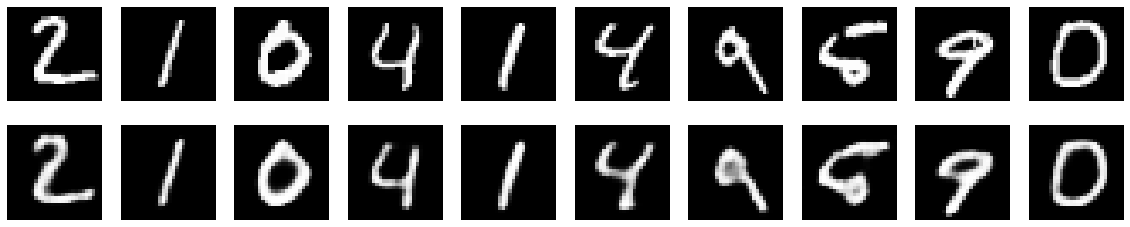

In [88]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize = (20, 4))

for i in range(1, 11):
  ax = plt.subplot(2, 10, i)

  # 원본 데이터
  plt.imshow(x_test[i].reshape((28, 28)), cmap = 'gray')
  plt.axis('off')

  # 오토인코더로 재구성된 데이터
  ax = plt.subplot(2, 10, i + 10)
  plt.imshow(decoded_imgs[i].reshape((28, 28)), cmap = 'gray')
  plt.axis('off')
plt.show()

# 이미지 노이즈 제거
- 이미지 노이즈 제거(denoising)하는데도 오토인코더가 쓰임
- 노이지한 이미지를 클린한 이미지로 매핑하도록 훈련시켜보겠음

In [89]:
# 노이즈 만들기
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(0.0, 1.0, size = x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(0.0, 1.0, size = x_test.shape)

In [92]:
x_train[0].reshape(-1), x_train_noisy[0].reshape(-1)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [93]:
# 0보다 작은값은 0으로, 1보다 큰값은 1로 변환
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

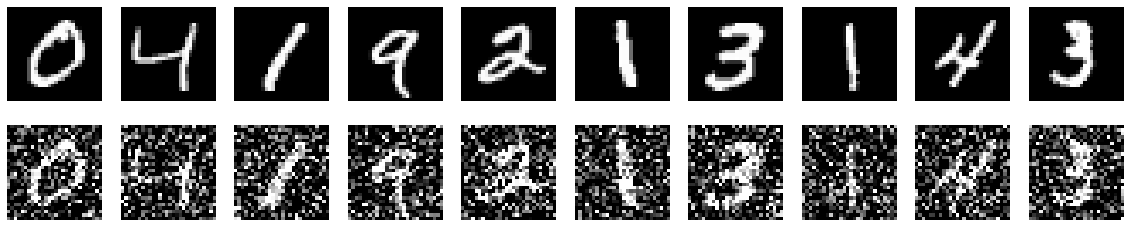

In [95]:
# 시각화

plt.figure(figsize = (20,4))
for i in range(1,11):
  # 원본 사진
  plt.subplot(2, 10, i)
  plt.imshow(x_train[i].reshape((28,28)), cmap = 'gray')
  plt.axis('off')

  # 노이즈 추가 사진
  plt.subplot(2, 10, i+10)
  plt.imshow(x_train_noisy[i].reshape((28,28)), cmap = 'gray')
  plt.axis('off')
plt.show()

- 이제 위의 합성곱층으로 구성된 오토인코더를 수정해보겠음
- 재구성된 이미지의 질을 향상시키기 위해 layer당 더 많은 필터를 사용해보겠음

In [121]:
input_img = Input(shape = (28, 28, 1))

encoded = Conv2D(32, 3, activation = 'relu', padding = 'same')(input_img)
encoded = MaxPooling2D(2, padding = 'same')(encoded)
encoded = Conv2D(32, 3, activation = 'relu', padding = 'same')(encoded)
encoded = MaxPooling2D(2, padding = 'same')(encoded)

decoded = Conv2D(32, 3, activation = 'relu', padding = 'same')(encoded)
decoded = UpSampling2D(2)(decoded)
decoded = Conv2D(32, 3, activation = 'relu', padding = 'same')(decoded)
decoded = UpSampling2D(2)(decoded)
decoded = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(decoded)

autoencoder = Model(input_img, decoded)

In [122]:
autoencoder.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_118 (Conv2D)         (None, 7, 7, 32)          924

In [123]:
encoder = Model(input_img, encoded)

encoder_input = Input(shape = (7,7,32))
decoded_layer = autoencoder.layers[5](encoder_input)
for i in range(6, len(autoencoder.layers)):
  decoded_layer = autoencoder.layers[i](decoded_layer)
decoder = Model(encoder_input, decoded_layer)

In [124]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs = 100,
                batch_size = 128,
                validation_data = (x_test_noisy, x_test))

Epoch 1/100
469/469 [==============================] - 5s 7ms/step - loss: 0.1667 - val_loss: 0.1147
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1119 - val_loss: 0.1078
Epoch 3/100
469/469 [==============================] - 4s 7ms/step - loss: 0.1066 - val_loss: 0.1042
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1038 - val_loss: 0.1017
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1020 - val_loss: 0.1007
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1007 - val_loss: 0.0995
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0998 - val_loss: 0.0986
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0990 - val_loss: 0.0978
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0984 - val_loss: 0.0974
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0979 - val_lo

313/313 [==============================] - 1s 2ms/step


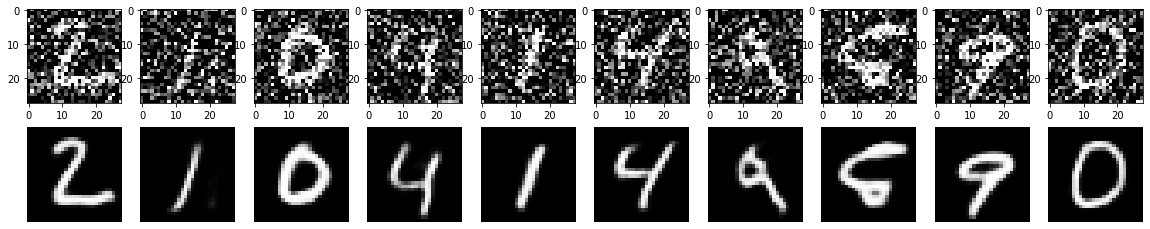

In [125]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)
 
n = 10  # 이미지 개수
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # 원본 데이터
    plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape((28,28)), cmap = 'gray')
    ax.axis('off')
 
    # 재구성된 데이터
    plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape((28,28)), cmap = 'gray')
    plt.axis('off')
plt.show()
